In [1]:
from simulator import MdUpdate, Order, OwnTrade, Sim, update_best_positions
from get_info import get_pnl
from load_data import load_md_from_file
from typing import List, Optional, Tuple, Union, Dict

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import math
import bisect
import random
from math import e, sqrt, log, pi
from collections import defaultdict, deque

In [16]:
Tsmall = pd.Timedelta(20, 'm').delta
T6h = pd.Timedelta(6, 'h').delta
Tlrg = pd.Timedelta(25, 'h').delta

PATH_TO_FILE_ETH = '../md/ethusdt_Binance_LinearPerpetual/'
PATH_TO_FILE_BTC = '../md/btcusdt_Binance_LinearPerpetual/'

md_small_eth = load_md_from_file(path=PATH_TO_FILE_ETH, T = Tsmall)
md_small_btc = load_md_from_file(path=PATH_TO_FILE_BTC, T = Tsmall)

md_6h_eth = load_md_from_file(path=PATH_TO_FILE_ETH, T = T6h)
md_6h_btc = load_md_from_file(path=PATH_TO_FILE_BTC, T = T6h)

md_large_eth = load_md_from_file(path=PATH_TO_FILE_ETH, T = Tlrg)
md_large_btc = load_md_from_file(path=PATH_TO_FILE_BTC, T = Tlrg)

In [406]:
crs = ['#9f0f0f', 'g', 'b', 'y', 'c', 'gray', 'm', 'pink', 'slateblue', 'olivedrab', 'lightsalmon', 'linen', 'tan']

def plot_xy(xs, ys, ytitle, marker = '-'):
    plt.figure(figsize=(16, 5))
    plt.plot(xs, ys, marker, color = crs[2])

    plt.xlabel("Time", fontsize=13)
    plt.ylabel(ytitle, fontsize=13)
    plt.title(ytitle, fontsize=15)

    # plt.legend(loc='lower left')
    plt.grid()
    plt.show()

In [388]:
class Logger:
    def __init__(self, n_quantize = 11):
        self.m = n_quantize
        self.data = []
        self.quantize = []
        self.processed = None
        self.eps = 0.00001
        
    def append(self, x):
        self.data.append(x)
    
    def x2q(self, x):
        for i, v in enumerate(self.quantize):
            if x <= v + self.eps:
                return i
        return self.m - 1
    
    def infer_quantizer(self):
        sl = sorted(self.data)
        N = len(sl)
        
        for i in range(1, self.m):
            self.quantize.append(sl[N * i // self.m])
            
        self.processed = [self.x2q(x) for x in self.data]
            
    def set_quantizer(self, q):
        self.quantize = q
        self.m = len(q) + 1
        
        self.processed = [self.x2q(x) for x in self.data]
    
    def get_raw_data(self):
        return self.data
    
    def get_processed_data(self):
        return self.processed

In [389]:
def round_base(x, base):
    base = round(1 / base)
    return round(x * base) / base

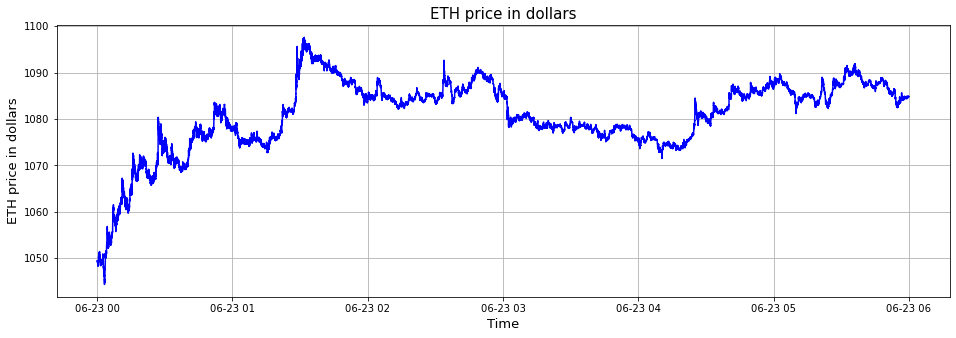

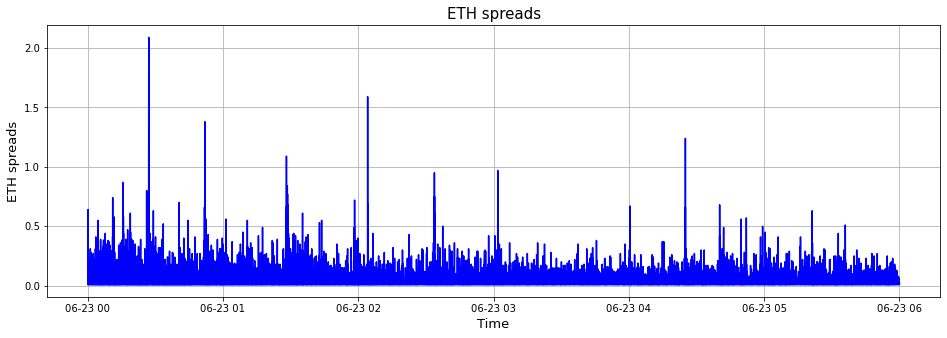

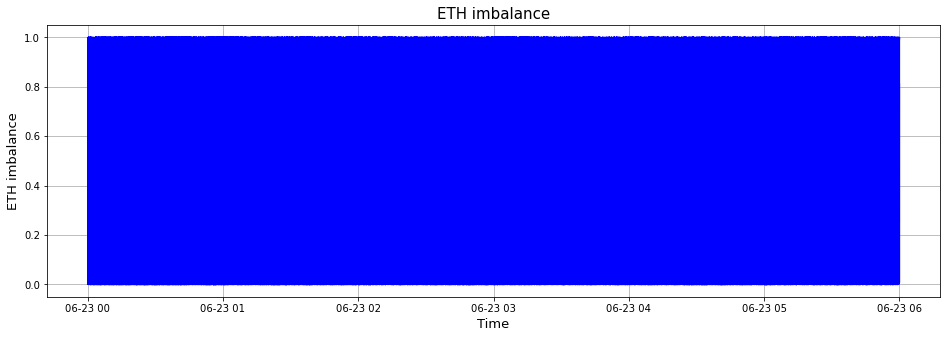

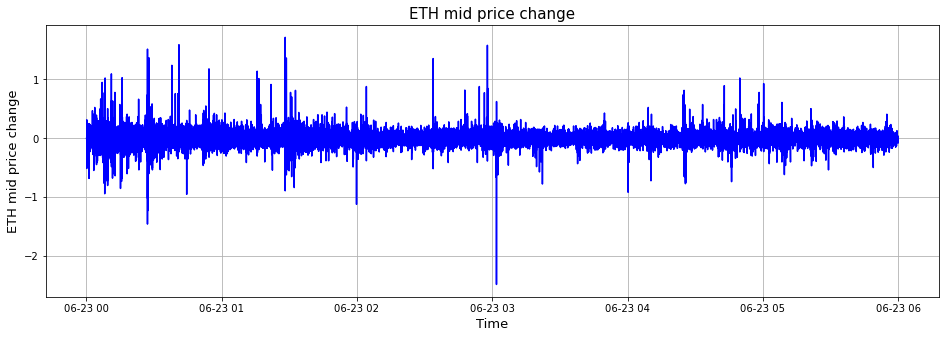

10%, 20%,... 90% quantiles of spread [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
10%, 20%,... 90% quantiles of imbalance [0.019, 0.078, 0.176, 0.297, 0.43, 0.568, 0.699, 0.82, 0.917, 0.979]
10%, 20%,... 90% quantiles of price changes [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [390]:
coin = 'ETH'
md_run = md_6h_eth
tick = 0.01

spread_log = Logger()
imbalance_log = Logger()
price_log = Logger()

ts = []
prices = []
ct = defaultdict(int)

for md in md_run:
    if md.orderbook:
        ob = md.orderbook
        ap, av = ob.asks[0]
        bp, bv = ob.bids[0]

        mp = (ap + bp) / 2
        s = ap - bp
        I = bv / (av + bv)
        
        spread_log.append(round_base(s, base = tick))
        imbalance_log.append(round_base(I, base = 0.001))
        if len(prices):
            price_log.append(mp - prices[-1])
        
        prices.append(mp)
        ct[round_base(s, base = tick)] += 1
        ts.append(md.exchange_ts)

ts = pd.to_datetime(ts)
plot_xy(ts, prices, '%s price in dollars' % coin)
plot_xy(ts, spread_log.get_raw_data(), '%s spreads' % coin)
plot_xy(ts, imbalance_log.get_raw_data(), '%s imbalance' % coin)
plot_xy(ts[:-1], price_log.get_raw_data(), '%s mid price change' % coin)

spread_log.infer_quantizer()
imbalance_log.infer_quantizer()
price_log.infer_quantizer()

print('10%, 20%,... 90% quantiles of spread', spread_log.quantize)
print('10%, 20%,... 90% quantiles of imbalance', imbalance_log.quantize)
print('10%, 20%,... 90% quantiles of price changes', price_log.quantize)

#### Мысли

Я пытаюсь дискретизировать имбаланс, спред, изменение цены через их квантили.

<i>Imbalance</i>. Мы видим квантили 10%, 20%, ..., 90% имбаланса на второй строке. И что они более менее симметричны вокруг 0.5.

<i>Spread</i>. Что же касается спреда, его 90% квантиль это просто размер тика. Поэтому по другому нужно дискретизировать. Больше 90% данных имеет одинаковый спред 0.01.

<i>Price change</i>. Квантили мид прайс изменений тоже не показательны. Большинство данных имеет нулевую разницу цен.

In [391]:
"""
    Look at spreads, infer some statistics
"""

sl = sorted(ct.items())
spr, count = zip(*sl)
print(sum(count))
print(sl[:10])
print(sl[-10:])

sm = 0
for a, b in sl:
    if a >= 0.3:
        sm += b

print(sm)

636117
[(0.01, 598327), (0.02, 8348), (0.03, 5942), (0.04, 4754), (0.05, 3522), (0.06, 2618), (0.07, 1909), (0.08, 1635), (0.09, 1381), (0.1, 1188)]
[(1.05, 1), (1.09, 1), (1.17, 1), (1.24, 1), (1.38, 1), (1.45, 1), (1.49, 1), (1.59, 1), (1.96, 1), (2.09, 1)]
658


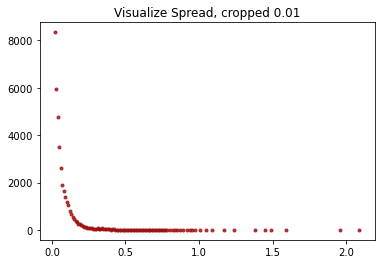

In [392]:
"""
    Plot spreads
"""

fig, ax = plt.subplots()
ax.plot(spr[1:], count[1:], '.', color='#9f0f0f', alpha=0.8)

plt.title('Visualize Spread, cropped 0.01')
plt.show()

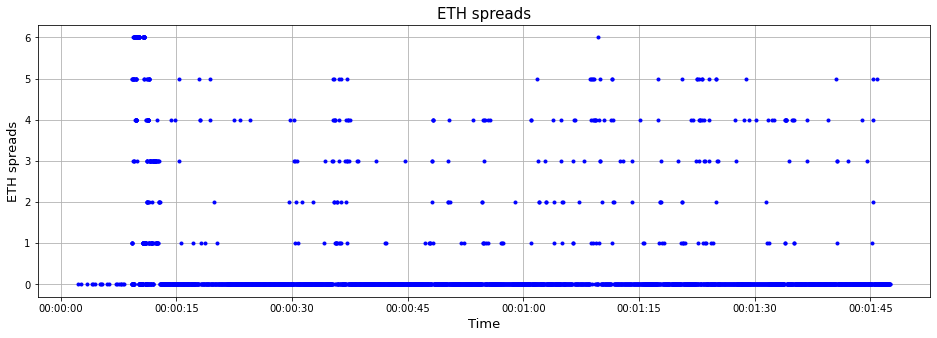

In [393]:
"""
    Set quantizer for spreads
    Я ставлю свои границы для дискретизации спреда
    
    На всех графиках ниже, я визуализирую данные на основе их дискретных значений.
"""

quantize = [tick, 2 * tick, 3 * tick, 5 * tick, 10 * tick, 30 * tick]
spread_log.set_quantizer(quantize)
plot_xy(ts[:3000], spread_log.get_processed_data()[:3000], '%s spreads' % coin, '.')

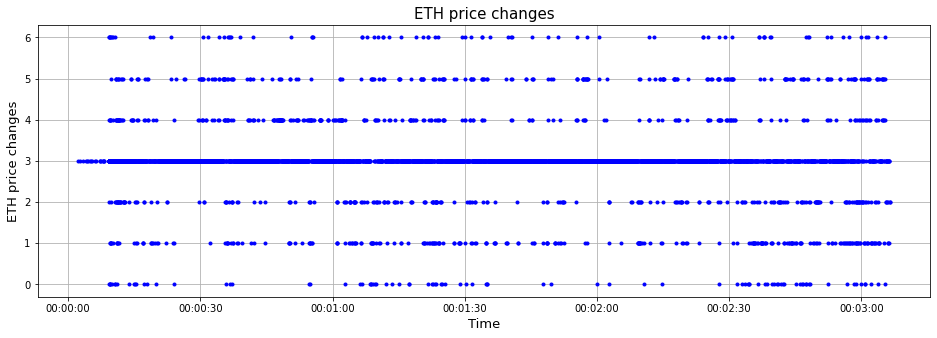

average values in quantiles, used for K vector
[-0.16, -0.053, -0.014, 0.0, 0.014, 0.053, 0.16]


In [394]:
"""
    Квантизируем изменение цены
    0: <= -10 tick
    1: <= -3 tick
    2: <= -1/2 tick
    3: == 0
    4: < 3 * tick
    5: < 10 * tick
    6: >= 10 * tick
"""

quantize = [-10 * tick, -3 * tick, -1/2 * tick, 0, 2.9 * tick, 9.9 * tick]
k = len(quantize) + 1

price_log.set_quantizer(quantize)
plot_xy(ts[:5000], price_log.get_processed_data()[:5000], '%s price changes' % coin, '.')

price_raw = price_log.get_raw_data()
stat = [[] for _ in range(k)]
q2v = [0] * k
for price in price_raw:
    quantile = price_log.x2q(price)
    stat[quantile].append(price)

    # symmetry of price changes
    quantile = price_log.x2q(-price)
    stat[quantile].append(-price)
    
for i in range(k):
    average_value = sum(stat[i]) / len(stat[i])
    q2v[i] = round_base(average_value, 0.001)
    
print('average values in quantiles, used for K vector')
print(q2v)

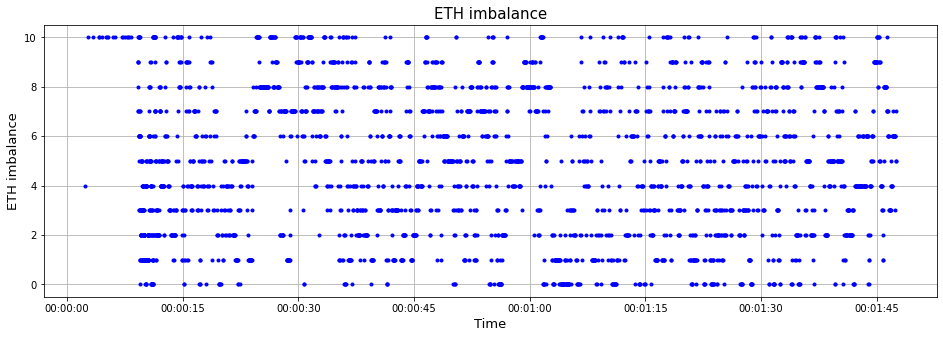

In [395]:
"""
    Изпользуем 10%, 20%, ... 90% квантили для дискретизации имбаланса. 
"""

plot_xy(ts[:3000], imbalance_log.get_processed_data()[:3000], '%s imbalance' % coin, '.')

In [399]:
"""
    Я готовлю данные

    state_t = (spread_t, imbalance_t)
    data = [(state_t, state_t+1, delta_price)]
"""

    
T = len(prices)
data = []
sp = spread_log.get_processed_data()
im = imbalance_log.get_processed_data()
price_raw = price_log.get_raw_data()

IMB = len(imbalance_log.quantize) + 1
print(IMB)


def get_state(x, y):
    # spread, imbalance
    return x * IMB + y


for i in range(T - 1):
    state = get_state(sp[i], im[i])
    n_state = get_state(sp[i + 1], im[i + 1])
    dp = price_log.x2q(price_raw[i])
    data.append((state, n_state, dp))
    
    # symmetry
    state = get_state(sp[i], IMB-1 - im[i])
    n_state = get_state(sp[i + 1], IMB-1 - im[i + 1])
    data.append((state, n_state, 6 - dp))
    
print(data[:5])

11
[(4, 10, 3), (6, 0, 3), (10, 10, 3), (0, 0, 3), (10, 10, 3)]


In [400]:
"""
    Я высчитываю свои матрицы
"""

mn = (len(spread_log.quantize) + 1) * (len(imbalance_log.quantize) + 1)
print('State space size', mn)

K = np.array([q2v]).transpose()
R = np.zeros((mn, len(q2v)))
Q = np.zeros((mn, mn))
T = np.zeros((mn, mn))

for s, ns, dp in data:
    R[s, dp] += 1

    if dp == 3: # ZERO
        Q[s, ns] += 1
    else:
        T[s, ns] += 1
        
for s in range(mn):
    R[s] /= sum(R[s])
    
    total = sum(Q[s]) + sum(T[s])
    Q[s] /= total
    T[s] /= total

mm = np.matmul
iQ = np.linalg.inv(np.eye(mn) - Q)

G1 = mm(iQ, mm(R, K))
B = mm(iQ, T)

Gstar = np.zeros((mn, 1))
pwB = np.eye(mn)

def check_stochastic(mat):
    for i in range(len(mat)):
        if abs(sum(mat[i]) - 1) > eps:
            return False
    return True

for _ in range(1000):
    stoch = check_stochastic(pwB)
    if not stoch:
        print(_, 'Not stochastic')
        break
    
    Gstar += mm(pwB, G1)
    pwB = mm(pwB, B)
    
print('If below vector is zero, then converged')
print(sum(abs(mm(pwB, G1))))

State space size 77
If below vector is zero, then converged
[2.9967348e-16]


In [401]:
"""
    G1 - предиктит первое изменение
    Gstar = P_micro - M
"""

def get_interval(arr, i):
    if i == len(arr):
        return '> %0.3f' % arr[-1]
    return '<= %0.3f' % arr[i]

for spread in range(7):
    spr_str = get_interval(spread_log.quantize, spread)
    print('\nSpread', spr_str)
    for imbalance in range(10):
        s = get_state(spread, imbalance)
        imb_str = get_interval(imbalance_log.quantize, imbalance)
        print('Imbalance %s, G1 %0.4f, Gstar %0.4f'% (imb_str, G1[s][0], Gstar[s][0]))


Spread <= 0.010
Imbalance <= 0.019, G1 -0.0435, Gstar -0.0745
Imbalance <= 0.078, G1 -0.0351, Gstar -0.0577
Imbalance <= 0.176, G1 -0.0260, Gstar -0.0427
Imbalance <= 0.297, G1 -0.0175, Gstar -0.0287
Imbalance <= 0.430, G1 -0.0085, Gstar -0.0142
Imbalance <= 0.568, G1 -0.0000, Gstar -0.0000
Imbalance <= 0.699, G1 0.0085, Gstar 0.0142
Imbalance <= 0.820, G1 0.0175, Gstar 0.0287
Imbalance <= 0.917, G1 0.0260, Gstar 0.0427
Imbalance <= 0.979, G1 0.0351, Gstar 0.0577

Spread <= 0.020
Imbalance <= 0.019, G1 -0.0322, Gstar -0.0714
Imbalance <= 0.078, G1 -0.0192, Gstar -0.0506
Imbalance <= 0.176, G1 -0.0141, Gstar -0.0353
Imbalance <= 0.297, G1 -0.0085, Gstar -0.0244
Imbalance <= 0.430, G1 -0.0028, Gstar -0.0050
Imbalance <= 0.568, G1 0.0000, Gstar -0.0000
Imbalance <= 0.699, G1 0.0028, Gstar 0.0050
Imbalance <= 0.820, G1 0.0085, Gstar 0.0244
Imbalance <= 0.917, G1 0.0141, Gstar 0.0353
Imbalance <= 0.979, G1 0.0192, Gstar 0.0506

Spread <= 0.030
Imbalance <= 0.019, G1 -0.0346, Gstar -0.0743


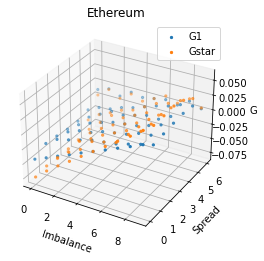

In [408]:
"""
    В 3д визулизировал тройку: spread, imbalance, G1 (one step predictor)
"""

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs, ys, zs, zs2 = [], [], [], []

for spread in range(7):
    for imbalance in range(10):
        s = get_state(spread, imbalance)
        xs.append(spread)
        ys.append(imbalance)
        zs.append(G1[s][0])
        zs2.append(Gstar[s][0])
        
ax.scatter(ys, xs, zs, marker='.', label='G1')
ax.scatter(ys, xs, zs2, marker='.', label='Gstar')

ax.set_xlabel('Imbalance')
ax.set_ylabel('Spread')
ax.set_zlabel('G')

plt.title('Ethereum')
plt.legend()
plt.show()

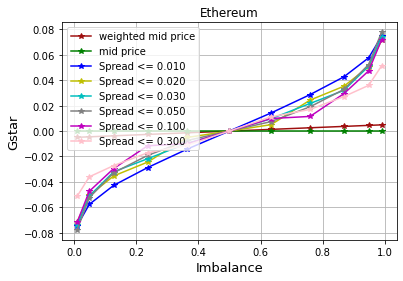

In [407]:
"""
    Для каждого спреда визуализирую двойку: Imbalance, Gstar
"""
imb = [0] + imbalance_log.quantize + [1]
sample_imbalance = [(imb[i] + imb[i + 1]) / 2 for i in range(len(imb) - 1)]

xs = []
ys = []
for imbalance in sample_imbalance:
    xs.append(imbalance)
    ys.append((2 * imbalance - 1) * tick / 2)

plt.plot(xs, ys, '-', marker='*', color = crs[0], label='weighted mid price')
plt.plot(xs, [0] * len(ys), '-', marker='*', color = crs[1], label='mid price')
    

for spread in range(6):
    ys = []
    for imbalance in sample_imbalance:
        qi = imbalance_log.x2q(imbalance)
        s = get_state(spread, qi)
        ys.append(Gstar[s][0])
        

    plt.plot(xs, ys, '-', marker='*', color = crs[spread + 2], label='Spread %s'%get_interval(spread_log.quantize, spread))


plt.title('Ethereum')
plt.xlabel('Imbalance', fontsize=13)
plt.ylabel('Gstar', fontsize=13)

plt.legend()
plt.grid()
plt.show()